# import

In [1]:
from Utilities.utils import *

# Get the current working directory
current_working_dir = os.path.join(Path(os.getcwd()).parent,'data') 
figure5_data_dict = load_h5(os.path.join(current_working_dir,r"f5_data.h5"))


dark_pink = '#BE575F'
dark_blue = '#232C56'

# figure B

100%|██████████| 10000/10000 [00:17<00:00, 575.52it/s]


(0.0, 4000.0)

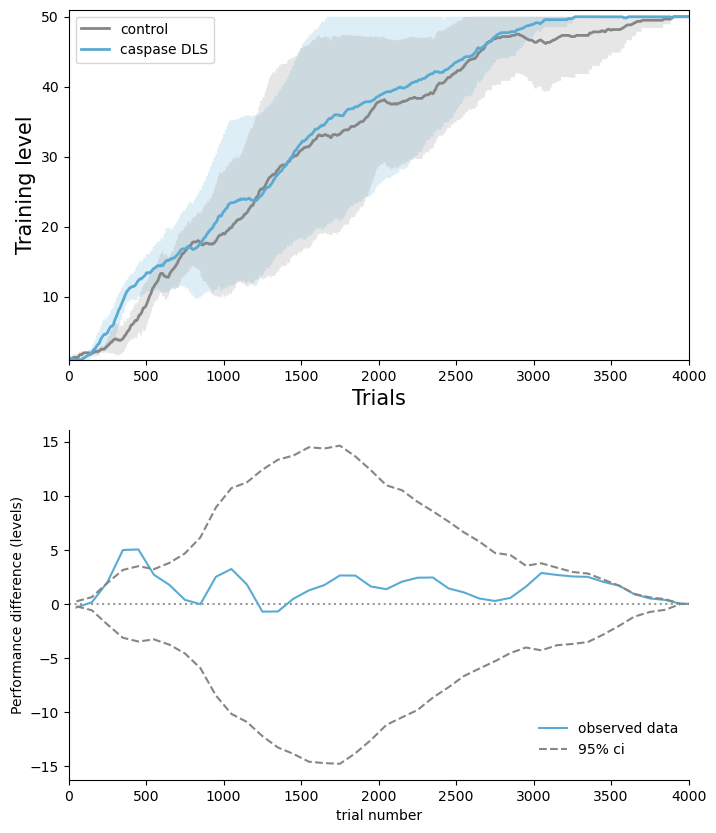

In [3]:

# 1. LOAD DATA - Read in CSV
pl_data = figure5_data_dict['pl_data']
# Extract data
categories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = parse_training_levels(pl_data.training_levels.values)

# Calculate mean and std for lesion and control groups
lesion_mask = categories == 'lesion'
lesion_MeanlesionCurve, lesion_std = calculate_mean_std(t_levels, lesion_mask)

control_mask = categories == 'control'
control_MeanlesionCurve, control_std = calculate_mean_std(t_levels, control_mask)

# Plot
%matplotlib inline
window = 10
xlim = 4000

fig, [ax,ax2] = plt.subplots(2, 1, figsize=(8, 10))
ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

ax.plot(convolve_movmean(control_MeanlesionCurve[:xlim], window), '-', color="#868686", linewidth=2,label = 'control')
ax.plot(convolve_movmean(lesion_MeanlesionCurve[:xlim], window), '-', color='#5AABD3', linewidth=2,label = 'caspase DLS')

ax.set_xlabel('Trials', fontsize=15)
ax.set_ylabel('Training level', fontsize=15)

fill_between_mean_std(ax, lesion_MeanlesionCurve, lesion_std, "#5AABD3",xlim)
fill_between_mean_std(ax, control_MeanlesionCurve, control_std, "#868686",xlim)
ax.legend()


############ PLOT 2 - obsevred vs shuffle #########

# Set cut-off for number of trials to consider
cut = 4000
# Initialize lists to store data
new, group, cum_trials, animalid = [], [], [], []
# Process each item in t_levels
for index, item in enumerate(t_levels):
    new += item[0:cut]  # Append the first 'cut' elements of the current item
    group += cut * ['lesion' if index < len(t_levels) / 2 else 'control']  # Assign group
    animalid += [animals[index]] * cut  # Append animal ID
    cum_trials += list(np.linspace(1, cut, cut))  # Generate cumulative trial numbers
# Create DataFrame with collected data
df = pd.DataFrame({'CumTrials': cum_trials, 'Level': new, 'Group': group, 'ID': animalid})
# Define function to generate experimental group labels
def generate_eg(list_size, prob, hue_order):
    return [hue_order[0] if random.random() < prob else hue_order[1] for _ in range(list_size)]

# define a 100-trial window to bin the data
XBIN = 100
# Bin trial indices
df["TrialIndexBinned"] = (df.CumTrials.values // XBIN) * XBIN + XBIN / 2
# Group by 'ID', 'Group', 'TrialIndexBinned' and calculate mean
df_bintr = df.groupby(['ID', 'Group', 'TrialIndexBinned']).mean().reset_index()
df_bintr['Performance'] = df_bintr.Level
hue_order = ['control', 'lesion']
# Calculate performance difference between groups
perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
# Select necessary columns
df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()
# Calculate probability for experimental group
exp_gr = [df_colsel[df_colsel.ID == x].Group.unique()[0] for x in df_colsel.ID.unique()]
cb_prob = sum([x == hue_order[0] for x in exp_gr]) / len(exp_gr)

# Seed for reproducibility
np.random.seed(124321)
# Shuffle results
shuff_res = []
# Shuffle and compute performance differences
NSH = 10000
for _ in tqdm(range(NSH)):
    exp_grs = generate_eg(len(exp_gr), cb_prob,hue_order)
    egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
    df_colsel['egs'] = df_colsel.ID.map(egs_dict)
    diff = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
           df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
    shuff_res.append(diff)
shrdf = pd.concat(shuff_res)

# Calculate real data performance difference
real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
real_data *= -1

# Plot results
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

ax2.axhline(0, ls='dotted', alpha=0.4, color='k')
ax2.plot(real_data, color='#5AABD3', label='observed data')
ax2.plot(pos_ci, linestyle='--', color='#868686', label='95% ci')
ax2.plot(neg_ci, linestyle='--', color='#868686')

x = pos_ci.reset_index().TrialIndexBinned
y1 = neg_ci.reset_index().Performance
y2 = real_data.reset_index().Performance

ax2.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#5AABD3', alpha=.3, interpolate=True)
ax2.set_ylabel('Performance difference (levels)')
ax2.set_xlabel('trial number')
ax2.legend(loc=(0.75, 0.05), frameon=False)
ax2 = plt.gca()
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim((0, 4000))


# figure D

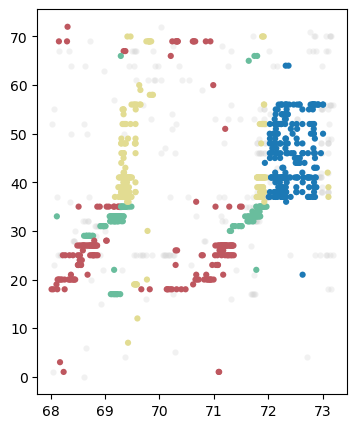

In [4]:
## plotting:
nrow = 1
ncol = 1
fig, ax = plt.subplots(nrow, ncol,figsize=(4, 5))
# plot background in grey 
ax.scatter(figure5_data_dict['h_lesion_replays_example_dict']['background_spike'], figure5_data_dict['h_lesion_replays_example_dict']['background_neuron_order'],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.3)
# plot spikes without background
ax.scatter(figure5_data_dict['h_lesion_replays_example_dict']['ppseq_spikes'], figure5_data_dict['h_lesion_replays_example_dict']['ppseq_neuron_order'],marker = 'o', s=20, linewidth=0,color = figure5_data_dict['h_lesion_replays_example_dict']['ppseq_color'],alpha=1)


# figure F

c:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\figure5\Utilities\utils.py:780: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
c:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\figure5\Utilities\utils.py:781: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()
c:\miniconda\envs\proc_replay_2025\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6727.
  res = hypotest_fun_out(*samples, **kwds)


--- x-axis ---
 Shapiro–Wilk:    W=0.962, p=0.000 -> non-normal
 D’Agostino K²: K²=950.775, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.963, p=0.000 -> non-normal
 D’Agostino K²: K²=2709.202, p=0.000 -> non-normal

------------------ expert only regression ------------------------------------------
r = 0.633822824300782
r^2 = 0.4017313726046199
p-value = 0.0
------------------------------------------------------------
--- x-axis ---
 Shapiro–Wilk:    W=0.956, p=0.000 -> non-normal
 D’Agostino K²: K²=294.539, p=0.000 -> non-normal

--- y-axis ---
 Shapiro–Wilk:    W=0.930, p=0.000 -> non-normal
 D’Agostino K²: K²=4626.179, p=0.000 -> non-normal

data isnt normal so permanova for forward late vs early
***************************************************
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             0.015783
p-value                       0.923
number 

c:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\figure5\Utilities\utils.py:780: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['x'].mean()
c:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\figure5\Utilities\utils.py:781: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_std = df.groupby('bin')['x'].std()


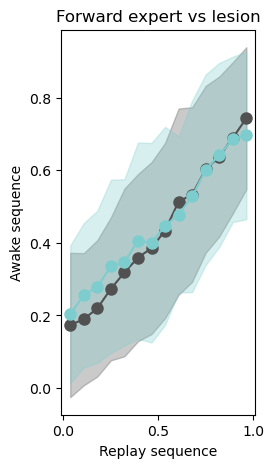

In [5]:
hlesion_master = figure5_data_dict['h_lesion']
expert_master = figure5_data_dict['expert']

fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
x = expert_master['neuron_rel_forward_replay_positions']
x = [item for sublist in x for item in sublist]
y = expert_master['neuron_rel_awake_positions_forwards']
y = [item for sublist in y for item in sublist]
a,b = plot_sleep_awake_spike_position(ax,x,y, '#515151')
test_univariate_normality(x, y, alpha=0.05)

print('------------------ expert only regression ------------------------------------------')
import statsmodels.api as sm
group1_data = {'x': x, 'y': y}
df1 = pd.DataFrame(group1_data)
# Add a constant term to the independent variable
data = sm.add_constant(df1)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)
print(f"r = {r}")
print(f"r^2 = {model.rsquared}")
print(f"p-value = {model.pvalues['x']}")
print('------------------------------------------------------------')
x1 = hlesion_master['neuron_rel_forward_replay_positions']
x1 = [item for sublist in x1 for item in sublist]
y1 = hlesion_master['neuron_rel_awake_positions_forwards']
y1 = [item for sublist in y1 for item in sublist]
c,d= plot_sleep_awake_spike_position(ax,x1,y1, "#7ECDCE")
test_univariate_normality(x1, y1, alpha=0.05)

ax.set_title('Forward expert vs lesion')
ax.set_ylabel('Awake sequence'),ax.set_xlabel('Replay sequence')
print('data isnt normal so permanova for forward late vs early')

print_permanova_for_awake_sleep_neuron_positions(a,b,c,d)


# figure H

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


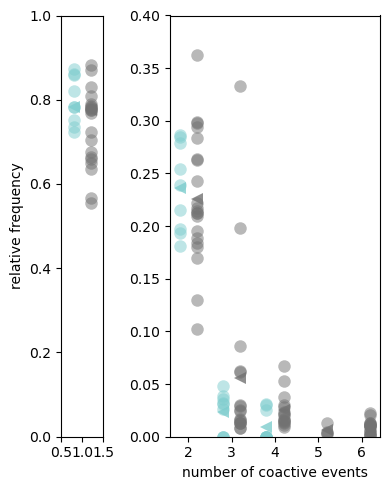

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             1.929107
p-value                    0.133587
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.62409


In [6]:
# ---------- data ----------
e_counts = collapse(convert_word_keys_to_numeric(expert_master['coactive_freqs']))
l_counts = collapse(convert_word_keys_to_numeric(hlesion_master['coactive_freqs']))

colors = {"expert": "#727272", "lesion": "#7ECDCE"}
offset = 0.2

# ---------- figure ----------
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(4, 5),
    gridspec_kw={'width_ratios': [2, 10]}
)

# left panel: coactive = 1 (median)
for counts, color, off in [
    (e_counts, colors["expert"], offset),
    (l_counts, colors["lesion"], -offset)
]:
    plot_group(ax1, counts, ['1'], off, color, np.median)

ax1.set_xlim(0.5, 1.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel('relative frequency')

# right panel: coactive >= 2 (mean)
keys = sorted([k for k in e_counts if k != '1'], key=float)
for counts, color, off in [
    (e_counts, colors["expert"], offset),
    (l_counts, colors["lesion"], -offset)
]:
    plot_group(ax2, counts, keys, off, color, np.mean)

ax2.set_xlabel('number of coactive events')
ax2.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()

### STATS
permanova_coactive_freqs(convert_word_keys_to_numeric(expert_master['coactive_freqs']), convert_word_keys_to_numeric(hlesion_master['coactive_freqs']))


# figure I

------------------


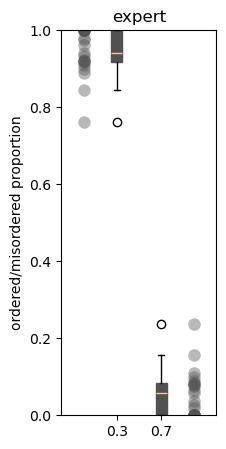

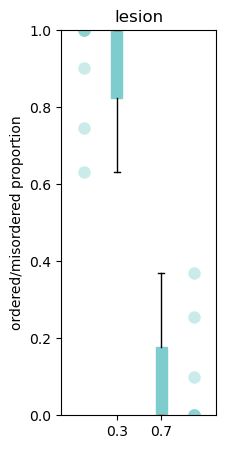

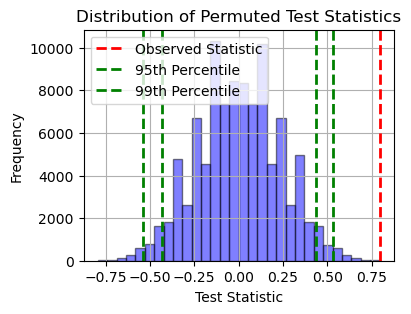

- p-value: 0.00026
- 99th percentile of permuted statistics: 0.5339845339845339
- Observed Test Statistic: 0.7937674270149195
cohens d = 5.2723039801951055
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  2
test statistic             1.298629
p-value                       0.279
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.49564
---------------------------------------------------


In [7]:
# plot
plot_ordered_misrodered(expert_master['ordered_misordered'],'expert','ordered/misordered proportion', '#515151')
plot_ordered_misrodered(hlesion_master['ordered_misordered'],'lesion','ordered/misordered proportion','#7ECDCE')

# STATS
print('------------------')
list1 = [float(item[0]) for item in hlesion_master['ordered_misordered']] 
list2 = [float(item[1]) for item in hlesion_master['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

## permanova - between groups
permanova_ordered_misordered(expert_master['ordered_misordered'], hlesion_master['ordered_misordered'])
print('---------------------------------------------------')

# figure J

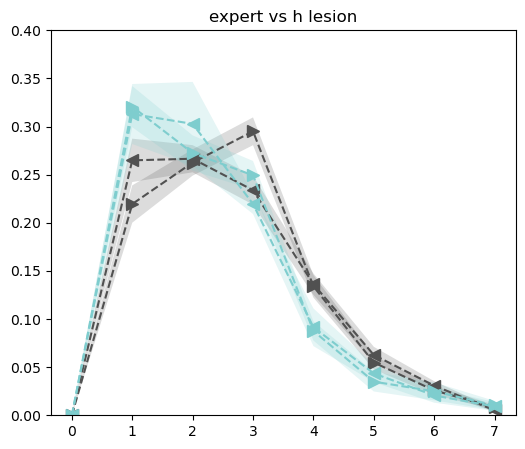

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             0.405624
p-value                    0.759224
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.71394
-----------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      60
number of groups                  2
test statistic             5.272963
p-value                      0.0033
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.72018
Significant feature-wise pairwise PERMANOVA results (α=0.05):
Feature 4: control vs test
  statistic = 10.4883, p (corr.) = 0.0168 *, R2: 0.5318
---


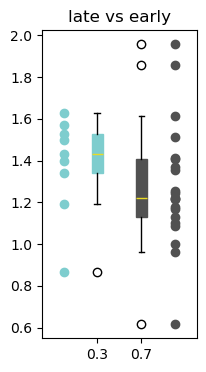

Test statistic: 4.9160732723687754
P-value: 0.0011697912995382955
ShapiroResult(statistic=np.float64(0.9482890816718307), pvalue=np.float64(0.31607121231820307))
ShapiroResult(statistic=np.float64(0.8717341034643624), pvalue=np.float64(0.12832095317352704))
TtestResult(statistic=np.float64(0.9322982681557084), pvalue=np.float64(0.3591523489259999), df=np.float64(28.0))
{'cohens_d': np.float64(0.3714365208442036)}


In [8]:

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

f_warp_factors, r_warp_factors, forward_total, reverse_total = extract_mean_warps(pd.DataFrame(expert_master['regression']), bins_)
lesion_f_warp_factors, lesion_r_warp_factors,  lesion_forward_total, lesion_reverse_total= extract_mean_warps(pd.DataFrame(hlesion_master['regression']), bins_)

# plot distributions
fig,ax = plt.subplots(1, 1,figsize=(6, 5))
color_ = '#515151'
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)
ax.set_title('expert vs h lesion')
color_ = '#7ECDCE'
plot_warp_factors(ax, lesion_f_warp_factors, lesion_r_warp_factors, bins_, color_)
ax.set_title('expert vs h lesion')
plt.show()

### STATS
# forward vs reverse for early lesion
permanova_forward_vs_reverse(lesion_f_warp_factors, lesion_r_warp_factors)
print('-----------------')
# PERMANOVA late vs early diff
el_grouping = group_difference_permanova(f_warp_factors, r_warp_factors, lesion_f_warp_factors, lesion_r_warp_factors)
# PAIRWISE PERMANOVA
# late vs early lesion
# Combine:
combined_data = np.vstack([
    np.asarray(f_warp_factors),
    np.asarray(r_warp_factors),
    np.asarray(lesion_f_warp_factors),
    np.asarray(lesion_r_warp_factors)
])
combined_labels = np.array(el_grouping)
feature_results = pairwise_permanova_by_feature(
    combined_data,
    combined_labels,
    method='bonferroni',
    permutations=10000)
print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
for res in feature_results:
    p = res["p_value"]
    if p < 0.05:
        stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
        print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
        print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}, R2: {res['R2']:.4f}")
        print("---")
        
        
################################### INSET

# plot inset
fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(forward_total)/np.array(reverse_total)
ax.plot(np.ones(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#515151')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#515151', color='#515151'), medianprops=dict(color="#EBDB24"))
lesion_proportion_forward_v_reverse = np.array(lesion_forward_total)/np.array(lesion_reverse_total)
ax.plot(np.zeros(len(lesion_proportion_forward_v_reverse)),lesion_proportion_forward_v_reverse,'o', color = '#7ECDCE')
ax.boxplot([x for x in lesion_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#7ECDCE', color='#7ECDCE'), medianprops=dict(color='#EBDB24'))
ax.set_title('late vs early')
plt.show()

## STATS
# Perform one-sample t-test
statistic, p_value = ttest_1samp(lesion_proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
effect_size(x=lesion_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1)

# early vs late difference:
print(scipy.stats.shapiro(proportion_forward_v_reverse))
print(scipy.stats.shapiro(lesion_proportion_forward_v_reverse))
## all normal so use ind t test
print(scipy.stats.ttest_ind(lesion_proportion_forward_v_reverse,proportion_forward_v_reverse))
print(effect_size(x=lesion_proportion_forward_v_reverse, y=proportion_forward_v_reverse, test='ttest'))


# figure K

-------------------
ShapiroResult(statistic=np.float64(0.9220872358994365), pvalue=np.float64(0.09553227620482058))
ShapiroResult(statistic=np.float64(0.9621845886732947), pvalue=np.float64(0.8208891175100859))
TtestResult(statistic=np.float64(0.543916603971253), pvalue=np.float64(0.5908040384854598), df=np.float64(28.0))
{'cohens_d': np.float64(0.2167015620528156)}


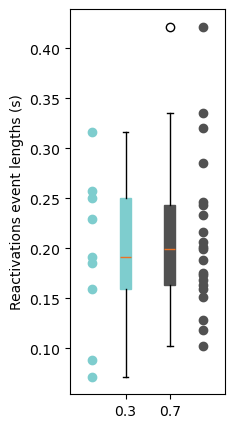

In [9]:
expert_event_lens = expert_master['event_lens']
hlesion_event_lens = hlesion_master['event_lens']

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.ones(len(expert_event_lens)), expert_event_lens, 'o', color = '#515151')
ax.boxplot(expert_event_lens, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#515151', color='#515151'), medianprops=dict(color='#EB7224'))

ax.plot(np.zeros(len(hlesion_event_lens)), hlesion_event_lens, 'o', color = '#7ECDCE')
ax.boxplot([x for x in hlesion_event_lens if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#7ECDCE', color='#7ECDCE'), medianprops=dict(color='#EB7224'))

ax.set_ylabel('Reactivations event lengths (s)')


## STATS
print('-------------------')

a = [x for x in expert_event_lens if not np.isnan(x)]
b = [x for x in hlesion_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))

print(effect_size(x=a, y=b, test='ttest'))



# figure L

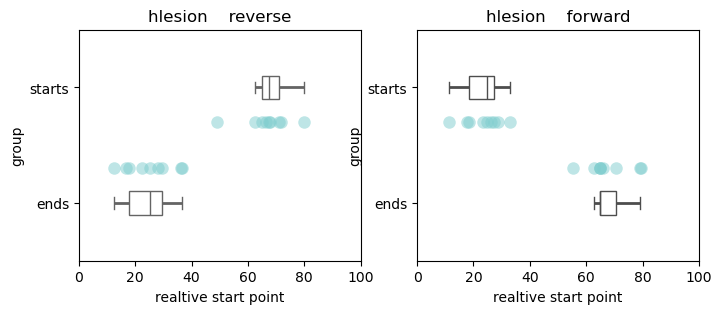

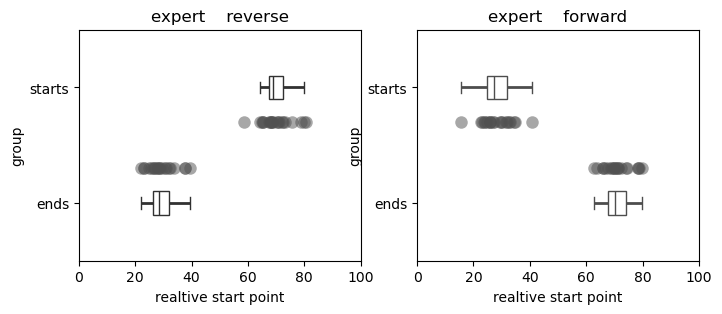

ShapiroResult(statistic=np.float64(0.9754605626019955), pvalue=np.float64(0.8480745849657958))
ShapiroResult(statistic=np.float64(0.9519369820631697), pvalue=np.float64(0.3703914541583487))
ShapiroResult(statistic=np.float64(0.9594133004721429), pvalue=np.float64(0.5043848873596806))
ShapiroResult(statistic=np.float64(0.9470380016996118), pvalue=np.float64(0.29908190783052324))
ShapiroResult(statistic=np.float64(0.9654667529552436), pvalue=np.float64(0.8534244014640447))
ShapiroResult(statistic=np.float64(0.8997514870082529), pvalue=np.float64(0.25056129203071))
ShapiroResult(statistic=np.float64(0.9159667432176966), pvalue=np.float64(0.3598950728279825))
ShapiroResult(statistic=np.float64(0.9522366864019227), pvalue=np.float64(0.7146209447657077))
_____________________________________________________________________________________________
                  Multivariate linear model
                                                              
----------------------------------------

In [10]:
fig,[ax,ax2] = plt.subplots(1, 2,figsize=(8, 3))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(hlesion_master['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'hlesion','#7ECDCE')
    
fig,[ax,ax2] = plt.subplots(1, 2,figsize=(8, 3)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(expert_master['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'expert','#515151')

plt.show()

### STATS
expert_all_chunk_reverse_start_mean, expert_all_chunk_forward_start_mean, expert_all_chunk_reverse_end_mean, expert_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(expert_master['start_end']))
hlesion_all_chunk_reverse_start_mean, hlesion_all_chunk_forward_start_mean, hlesion_all_chunk_reverse_end_mean, hlesion_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(hlesion_master['start_end']))

group1 = [x for x in expert_all_chunk_forward_start_mean if not np.isnan(x)] 
group2 = [x for x in expert_all_chunk_forward_end_mean if not np.isnan(x)] 
group3 = [x for x in expert_all_chunk_reverse_start_mean if not np.isnan(x)] 
group4 = [x for x in expert_all_chunk_reverse_end_mean if not np.isnan(x)] 
group5 = [x for x in hlesion_all_chunk_forward_start_mean if not np.isnan(x)] 
group6 = [x for x in hlesion_all_chunk_forward_end_mean if not np.isnan(x)] 
group7 = [x for x in hlesion_all_chunk_reverse_start_mean if not np.isnan(x)] 
group8 = [x for x in hlesion_all_chunk_reverse_end_mean if not np.isnan(x)] 
for group in [group1, group2, group3, group4, group5, group6, group7, group8]:
    print(scipy.stats.shapiro(group))

## all are normal so use MANOVA

df_late = pd.DataFrame({
    'group':       ['late'] * len(expert_all_chunk_forward_start_mean),
    'forward_start': expert_all_chunk_forward_start_mean,
    'forward_end':   expert_all_chunk_forward_end_mean,
    'reverse_start': expert_all_chunk_reverse_start_mean,
    'reverse_end':   expert_all_chunk_reverse_end_mean,
})
df_early = pd.DataFrame({
    'group':       ['early'] * len(hlesion_all_chunk_forward_start_mean),
    'forward_start': hlesion_all_chunk_forward_start_mean,
    'forward_end':   hlesion_all_chunk_forward_end_mean,
    'reverse_start': hlesion_all_chunk_reverse_start_mean,
    'reverse_end':   hlesion_all_chunk_reverse_end_mean,
})
print('_____________________________________________________________________________________________')
# Concatenate them:
df = pd.concat([df_late, df_early], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)


# figure M

Fitted parameters: a = 0.03267556939789752, b = 3.21309210901926
R-squared: 0.9926259080124209
p-values: [np.float64(1.7030314393595702e-05), np.float64(1.1325253623795106e-08)]
Fitted parameters: a = 0.04664708148092975, b = 2.8513090514436104
R-squared: 0.9804219671492419
p-values: [np.float64(0.00016736150012919282), np.float64(4.0646521592968554e-07)]
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3349 2.0000 17.0000 16.8834 0.0001
         Pillai's trace 0.6651 2.0000 17.0000 16.8834 0.0001
 Hotelling-Lawley trace 1.9863 2.0000 17.0000 16.8834 0.0001
    Roy's greatest root 1.9863 2.0000 17.0000 16.8834 0.0001
------------------------------------------------------------
                                                  

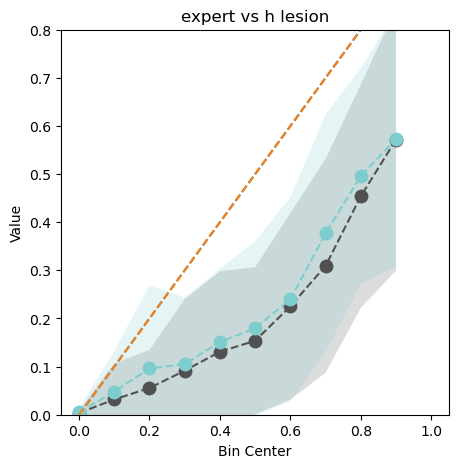

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
late_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(expert_master['awake_seqbyseq_neuron_involvements'],expert_master['sleep_seqbyseq_neuron_involvements'])
early_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(hlesion_master['awake_seqbyseq_neuron_involvements'],hlesion_master['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(late_awake_sleep_relationship,'#515151',ax)
plot_awake_sleep_relationship(early_awake_sleep_relationship,'#7ECDCE',ax)
ax.set_title('expert vs h lesion')

m = manova_groups_neuron_involvement(late_awake_sleep_relationship,early_awake_sleep_relationship)
# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)




# figure N

------------------


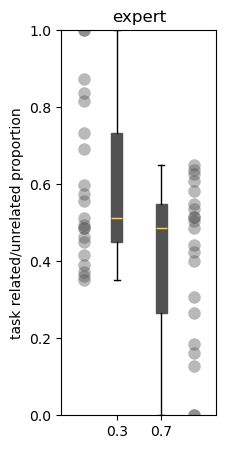

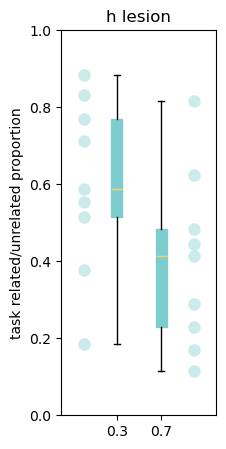

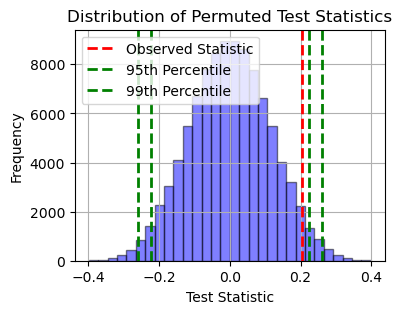

- p-value: 0.03836
- 99th percentile of permuted statistics: 0.2601457112012176
- Observed Test Statistic: 0.20309083127569588
cohens d = 0.8999170205608042
---------------------------------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.008128
p-value                       0.932
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.61690


In [12]:
plot_ordered_misrodered(expert_master['task_nontask'],'expert','task related/unrelated proportion','#515151')
plot_ordered_misrodered(hlesion_master['task_nontask'],'h lesion','task related/unrelated proportion','#7ECDCE')

print('------------------')
list1 = [float(item[0]) for item in hlesion_master['task_nontask']] 
list2 = [float(item[1]) for item in hlesion_master['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

## permanova - between groups
print('---------------------------------------------------')
permanova_ordered_misordered(expert_master['task_nontask'], hlesion_master['task_nontask'])
